# Multivariate Single Target multi Step Timeseries

We want to predict next 3 (in 4 hour time frame) close price of bitcoin based on multiple variate. We get BTC data from https://twelvedata.com api and do a time series analysis with different deep learning models. Finally we compare the result of different models on our data to figure out which model did the best on predicting the close price.

## import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## import data from API

In [1]:
pip install twelvedata

Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests
def get_crypto_price(symbol, interval,n_interval):
    api_key = 'put your api key here!'
    api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&exchange=binance&interval={interval}&outputsize={n_interval}&apikey={api_key}'
    raw = requests.get(api_url).json()
    df = pd.DataFrame(raw['values']).set_index('datetime')
    df = df.iloc[::-1]
    return df

dataset = get_crypto_price('BTC/USD', '4h',5000)
dataset

,open,high,low,close
datetime,,,,
2020-05-17 20:00:00,9770.71973,9793.91992,9630.00977,9680.00000
2020-05-18 00:00:00,9704.62988,9950.00000,9704.62988,9861.04980
2020-05-18 04:00:00,9861.13965,9905.00000,9746.08008,9775.45020
2020-05-18 08:00:00,9781.05957,9793.59961,9529.12988,9640.00000
2020-05-18 12:00:00,9630.48047,9730.74023,9573.33008,9665.00000
...,...,...,...,...
2022-08-29 16:00:00,20261.53906,20395.01953,20083.93945,20096.46094
2022-08-29 20:00:00,20101.61914,20345.97070,20083.30078,20295.58984
2022-08-30 00:00:00,20284.85938,20290.00000,20120.30078,20267.27930


## check and fill the missvalues

In [4]:
dataset.isnull().sum()

open     0
high     0
low      0
close    0
dtype: int64

## plot the multivariate timeseries

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 2020-05-17 20:00:00 to 2022-08-30 08:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   open    5000 non-null   object
 1   high    5000 non-null   object
 2   low     5000 non-null   object
 3   close   5000 non-null   object
dtypes: object(4)
memory usage: 195.3+ KB


In [6]:
dataset=dataset.iloc[:,:].astype(float)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 2020-05-17 20:00:00 to 2022-08-30 08:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    5000 non-null   float64
 1   high    5000 non-null   float64
 2   low     5000 non-null   float64
 3   close   5000 non-null   float64
dtypes: float64(4)
memory usage: 195.3+ KB


array([[<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>],
       [<AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>]], dtype=object)

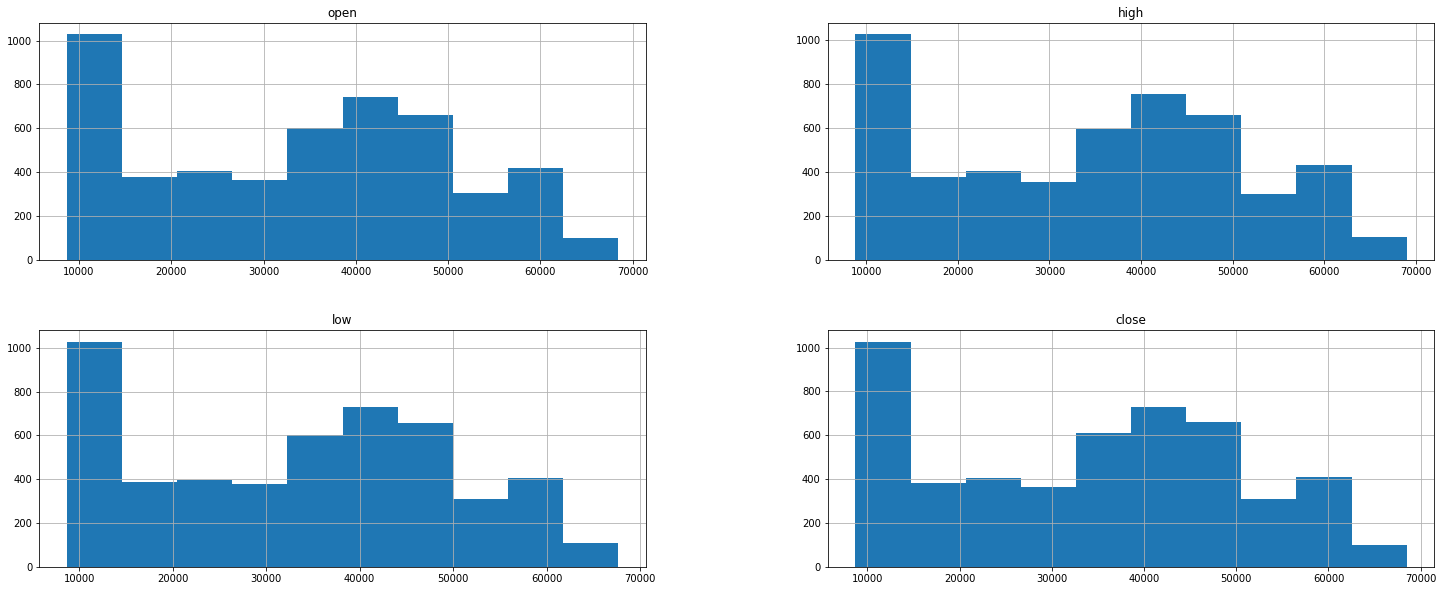

In [8]:
dataset.hist(figsize=(25,10))

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

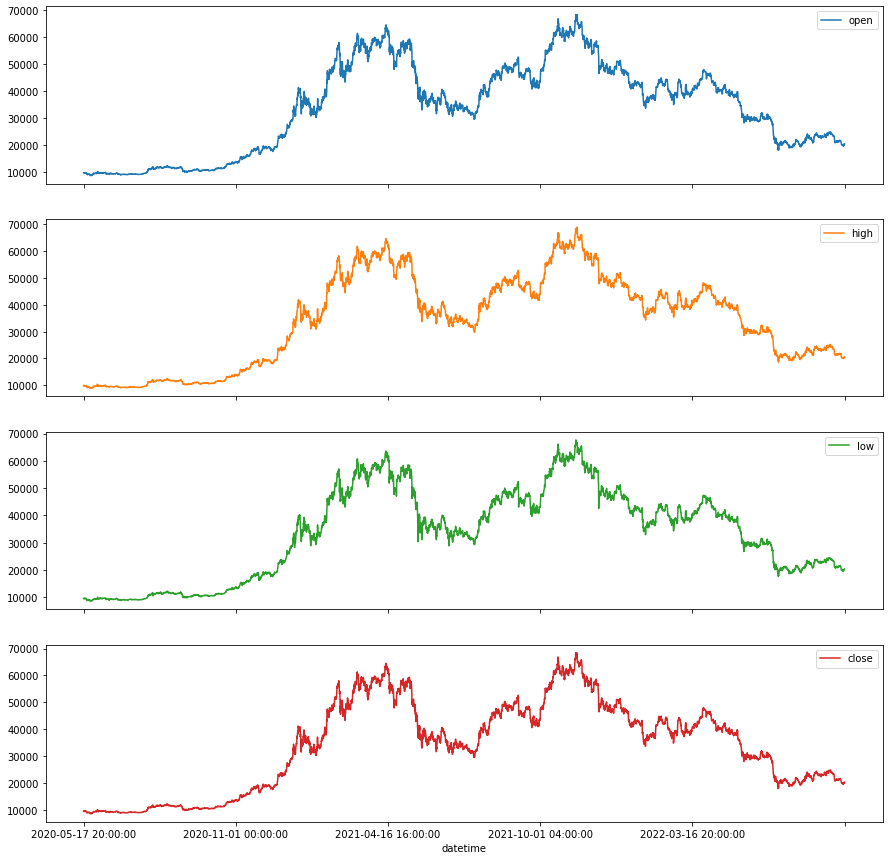

In [9]:
dataset.plot(subplots=True,figsize=(15,15))

## choose the optimal lag observation

In [10]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [11]:
import statsmodels.tsa.stattools as sts

In [12]:
dataset=pd.DataFrame(dataset)

In [13]:
sts.adfuller(dataset.close)

(-1.5799716605379857,
 0.49364610458285185,
 26,
 4973,
 {'1%': -3.431665640184842,
  '5%': -2.8621213700013244,
  '10%': -2.567079464076049},
 77835.23416574199)

In [14]:
df_diff=dataset.close.diff().dropna()

In [15]:
from statsmodels.graphics.tsaplots import plot_acf 

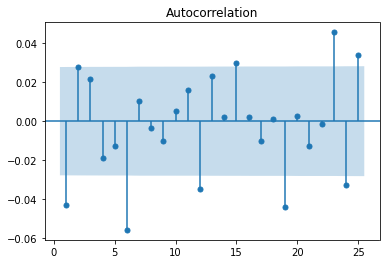

In [16]:
plot_acf(df_diff, lags=25,zero=False)   
plt.show()

In [17]:
lag=23

## Split the data

In [18]:
TRAIN_SPLIT=int(len(dataset)*0.8)

In [19]:
TRAIN_SPLIT

4000

In [20]:
dataset=np.array(dataset)

## to supervised

In [21]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [22]:
past_history = lag
STEP = 1
n_step=3

x_train_multi, y_train_multi= multivariate_data(dataset, dataset[:,3], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   n_step, STEP,
                                                   single_step=False)
x_test_multi, y_test_multi = multivariate_data(dataset, dataset[:, 3],
                                               TRAIN_SPLIT, None, past_history,
                                               n_step, STEP,
                                               single_step=False)

In [23]:
print(x_train_multi.shape)
print(x_test_multi.shape)


(3977, 23, 4)
(974, 23, 4)


In [24]:
print(y_train_multi.shape)
print(y_test_multi.shape)

(3977, 3)
(974, 3)


## scale data

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
scalers = {}
for i in range(x_train_multi.shape[1]):
    scalers [i]= MinMaxScaler(feature_range=(0,1))
    x_train_multi[:, i, :] = scalers[i].fit_transform(x_train_multi[:, i, :]) 

for i in range(x_test_multi.shape[1]):
    x_test_multi[:, i, :] = scalers[i].transform(x_test_multi[:, i, :]) 

In [27]:
x_train_multi.shape,x_test_multi.shape

((3977, 23, 4), (974, 23, 4))

In [28]:
scalers

{0: MinMaxScaler(),
 1: MinMaxScaler(),
 2: MinMaxScaler(),
 3: MinMaxScaler(),
 4: MinMaxScaler(),
 5: MinMaxScaler(),
 6: MinMaxScaler(),
 7: MinMaxScaler(),
 8: MinMaxScaler(),
 9: MinMaxScaler(),
 10: MinMaxScaler(),
 11: MinMaxScaler(),
 12: MinMaxScaler(),
 13: MinMaxScaler(),
 14: MinMaxScaler(),
 15: MinMaxScaler(),
 16: MinMaxScaler(),
 17: MinMaxScaler(),
 18: MinMaxScaler(),
 19: MinMaxScaler(),
 20: MinMaxScaler(),
 21: MinMaxScaler(),
 22: MinMaxScaler()}

In [29]:

scaler_y =MinMaxScaler(feature_range=(0,1))
y_train_multi=scaler_y.fit_transform(y_train_multi)
y_test_multi=scaler_y.transform(y_test_multi)


In [30]:
y_test_multi.shape,y_train_multi.shape

((974, 3), (3977, 3))

# Simple RNN

In [31]:
from keras.models import Sequential
from keras.layers import LSTM,Dense ,GRU,SimpleRNN,Conv1D,MaxPooling1D,Flatten , Dropout

In [32]:
RNN_model = Sequential()
RNN_model.add(SimpleRNN(50,input_shape=x_train_multi.shape[-2:],activation='relu',return_sequences=True))
# RNN_model.add(Dropout(0.3))
RNN_model.add(SimpleRNN(50,activation='relu',kernel_regularizer='l2'))
# RNN_model.add(Dropout(0.3))
RNN_model.add(Dense(n_step,activation='selu'))
RNN_model.compile(optimizer='adam', loss='mse')

In [33]:
history_RNN=RNN_model.fit(x_train_multi,y_train_multi,
                                            epochs=100,batch_size=16,validation_data=(x_test_multi,y_test_multi))

Epoch 1/100
249/249 [==============================] - 7s 18ms/step - loss: 0.2168 - val_loss: 0.0582
Epoch 2/100
249/249 [==============================] - 4s 15ms/step - loss: 0.0283 - val_loss: 0.0118
Epoch 3/100
249/249 [==============================] - 4s 15ms/step - loss: 0.0071 - val_loss: 0.0035
Epoch 4/100
249/249 [==============================] - 4s 16ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 5/100
249/249 [==============================] - 4s 16ms/step - loss: 0.0015 - val_loss: 8.1620e-04
Epoch 6/100
249/249 [==============================] - 4s 18ms/step - loss: 0.0013 - val_loss: 7.3925e-04
Epoch 7/100
249/249 [==============================] - 4s 18ms/step - loss: 9.7583e-04 - val_loss: 0.0016
Epoch 8/100
249/249 [==============================] - 5s 18ms/step - loss: 0.0010 - val_loss: 4.5674e-04
Epoch 9/100
249/249 [==============================] - 4s 17ms/step - loss: 8.3696e-04 - val_loss: 3.9847e-04
Epoch 10/100
249/249 [==============================] - 4s

## learning curve

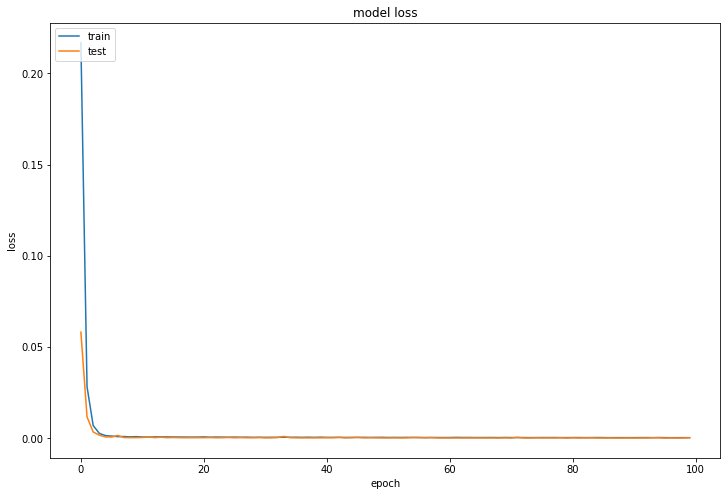

In [34]:
plt.figure(figsize=(12,8))
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict Test Set

In [35]:
predict_RNN=RNN_model.predict(x_test_multi)

31/31 [==============================] - 1s 6ms/step


In [36]:
predict_RNN.shape

(974, 3)

## MSE

In [37]:
from sklearn.metrics import mean_squared_error

In [38]:
mse_RNN= mean_squared_error(y_test_multi, predict_RNN)

In [39]:
mse_RNN

0.0002858596224005032

## Inverse Prediction

In [40]:
predict_RNN_inv=scaler_y.inverse_transform(predict_RNN)
y_test_multi_inv=scaler_y.inverse_transform(y_test_multi)

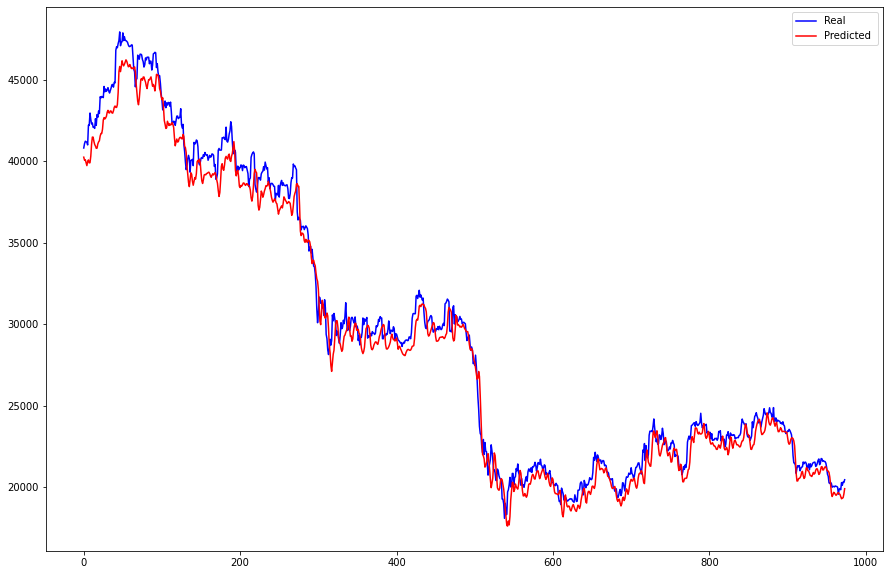

In [41]:
fig = plt.figure(figsize = (15,10))
plt.plot(y_test_multi_inv[:,2], color='b', label='Real ')
plt.plot(predict_RNN_inv[:,2], color='r', label='Predicted ')
plt.legend()

## predict next step

In [42]:
input_samples=x_test_multi[-1:,:,:]
input_samples.shape

(1, 23, 4)

In [43]:
next_step_RNN=RNN_model.predict(input_samples)
next_step_RNN.shape

1/1 [==============================] - 0s 49ms/step


(1, 3)

In [44]:
next_step_RNN

array([[0.18371922, 0.18882973, 0.18696232]], dtype=float32)

In [45]:
next_step_RNN_inv=scaler_y.inverse_transform(next_step_RNN)

In [46]:
next_step_RNN_inv

array([[19692.855, 19998.365, 19886.73 ]], dtype=float32)

# GRU

In [47]:
GRU_model = Sequential()
GRU_model.add(GRU(50,input_shape=x_train_multi.shape[-2:],activation='relu',return_sequences=True))
# GRU_model.add(Dropout(0.3))
GRU_model.add(GRU(50,activation='relu'))
# GRU_model.add(Dropout(0.3))
GRU_model.add(Dense(n_step,activation='selu'))
GRU_model.compile(optimizer='adam', loss='mse')

In [48]:
history_GRU=GRU_model.fit(x_train_multi,y_train_multi,
                                            epochs=100,batch_size=16,validation_data=(x_test_multi,y_test_multi))

Epoch 1/100
249/249 [==============================] - 13s 33ms/step - loss: 0.0123 - val_loss: 1.6882e-04
Epoch 2/100
249/249 [==============================] - 8s 31ms/step - loss: 3.5676e-04 - val_loss: 2.8391e-04
Epoch 3/100
249/249 [==============================] - 8s 31ms/step - loss: 3.5117e-04 - val_loss: 1.3974e-04
Epoch 4/100
249/249 [==============================] - 8s 31ms/step - loss: 3.2686e-04 - val_loss: 1.3543e-04
Epoch 5/100
249/249 [==============================] - 8s 31ms/step - loss: 3.1033e-04 - val_loss: 1.4872e-04
Epoch 6/100
249/249 [==============================] - 8s 30ms/step - loss: 3.2777e-04 - val_loss: 1.2953e-04
Epoch 7/100
249/249 [==============================] - 8s 31ms/step - loss: 3.2728e-04 - val_loss: 1.5011e-04
Epoch 8/100
249/249 [==============================] - 8s 31ms/step - loss: 3.0296e-04 - val_loss: 1.6521e-04
Epoch 9/100
249/249 [==============================] - 8s 30ms/step - loss: 3.0354e-04 - val_loss: 1.6405e-04
Epoch 10/100


Epoch 75/100
249/249 [==============================] - 7s 30ms/step - loss: 2.7102e-04 - val_loss: 1.3584e-04
Epoch 76/100
249/249 [==============================] - 7s 30ms/step - loss: 2.6211e-04 - val_loss: 1.1889e-04
Epoch 77/100
249/249 [==============================] - 8s 30ms/step - loss: 2.6344e-04 - val_loss: 1.0303e-04
Epoch 78/100
249/249 [==============================] - 8s 31ms/step - loss: 2.5720e-04 - val_loss: 1.6698e-04
Epoch 79/100
249/249 [==============================] - 8s 31ms/step - loss: 2.5256e-04 - val_loss: 1.4526e-04
Epoch 80/100
249/249 [==============================] - 7s 30ms/step - loss: 2.5660e-04 - val_loss: 1.1631e-04
Epoch 81/100
249/249 [==============================] - 8s 31ms/step - loss: 2.6512e-04 - val_loss: 1.0034e-04
Epoch 82/100
249/249 [==============================] - 8s 31ms/step - loss: 2.5403e-04 - val_loss: 1.6364e-04
Epoch 83/100
249/249 [==============================] - 8s 31ms/step - loss: 2.5799e-04 - val_loss: 9.9643e-05
E

## learning curve

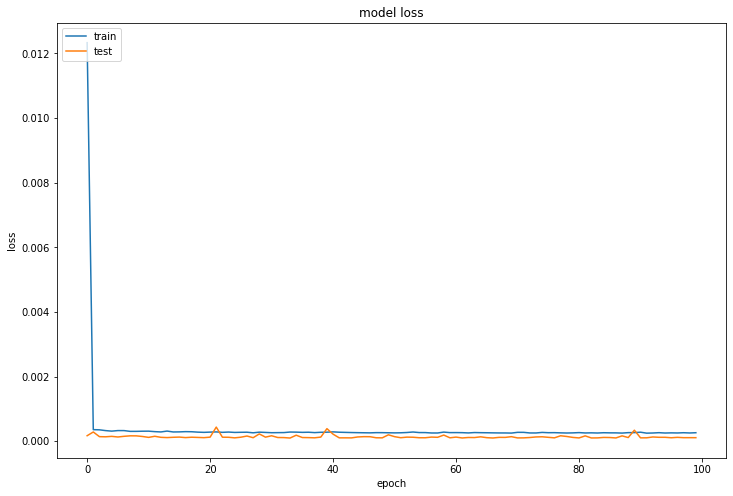

In [49]:
plt.figure(figsize=(12,8))
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict Test Set

In [50]:
predict_GRU=GRU_model.predict(x_test_multi)

31/31 [==============================] - 1s 11ms/step


In [51]:
predict_GRU.shape

(974, 3)

## MSE

In [52]:
mse_GRU= mean_squared_error(y_test_multi, predict_GRU)

In [53]:
mse_GRU

0.00010782485185452052

## Inverse Prediction

In [54]:
predict_GRU_inv=scaler_y.inverse_transform(predict_GRU)
#y_test_single_inv=scaler.inverse_transform(y_test_single)

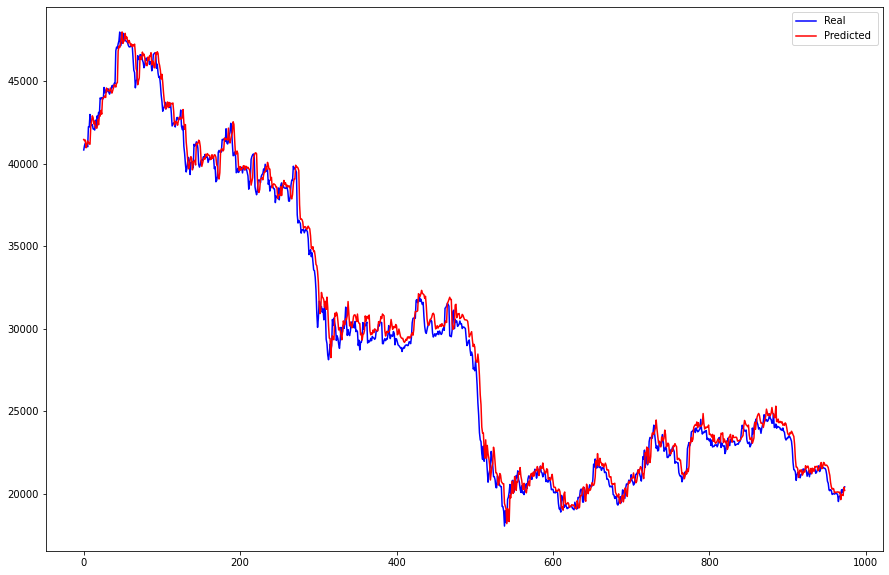

In [55]:
fig = plt.figure(figsize = (15,10))
plt.plot(y_test_multi_inv[:,2], color='b', label='Real ')
plt.plot(predict_GRU_inv[:,2], color='r', label='Predicted ')
plt.legend()

## predict next step

In [56]:
next_step_GRU=GRU_model.predict(input_samples)
next_step_GRU.shape

1/1 [==============================] - 0s 51ms/step


(1, 3)

In [57]:
next_step_GRU

array([[0.18800989, 0.1905883 , 0.19257742]], dtype=float32)

In [58]:
next_step_GRU_inv=scaler_y.inverse_transform(next_step_GRU)

In [59]:
next_step_GRU_inv

array([[19949.354, 20103.492, 20222.404]], dtype=float32)

# LSTM

In [60]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(50,input_shape=x_train_multi.shape[-2:],activation='relu',return_sequences=True))
# LSTM_model.add(Dropout(0.3))
LSTM_model.add(LSTM(50,activation='relu',return_sequences=True))
# LSTM_model.add(Dropout(0.3))
LSTM_model.add(LSTM(50,activation='relu'))
# LSTM_model.add(Dropout(0.3))
LSTM_model.add(Dense(n_step,activation='selu'))
LSTM_model.compile(optimizer='adam', loss='mse')

In [61]:
history_LSTM=LSTM_model.fit(x_train_multi,y_train_multi,
                                            epochs=100,batch_size=16,validation_data=(x_test_multi,y_test_multi))

Epoch 1/100
249/249 [==============================] - 19s 51ms/step - loss: 0.0188 - val_loss: 8.4132e-04
Epoch 2/100
249/249 [==============================] - 12s 47ms/step - loss: 0.0012 - val_loss: 6.7720e-04
Epoch 3/100
249/249 [==============================] - 12s 47ms/step - loss: 0.0010 - val_loss: 4.6516e-04
Epoch 4/100
249/249 [==============================] - 12s 47ms/step - loss: 9.7851e-04 - val_loss: 5.9484e-04
Epoch 5/100
249/249 [==============================] - 11s 46ms/step - loss: 8.1932e-04 - val_loss: 4.5367e-04
Epoch 6/100
249/249 [==============================] - 11s 46ms/step - loss: 7.8830e-04 - val_loss: 4.4629e-04
Epoch 7/100
249/249 [==============================] - 11s 46ms/step - loss: 7.6474e-04 - val_loss: 2.9920e-04
Epoch 8/100
249/249 [==============================] - 12s 46ms/step - loss: 6.9913e-04 - val_loss: 3.0447e-04
Epoch 9/100
249/249 [==============================] - 12s 46ms/step - loss: 5.2733e-04 - val_loss: 2.5630e-04
Epoch 10/100


## learning curve

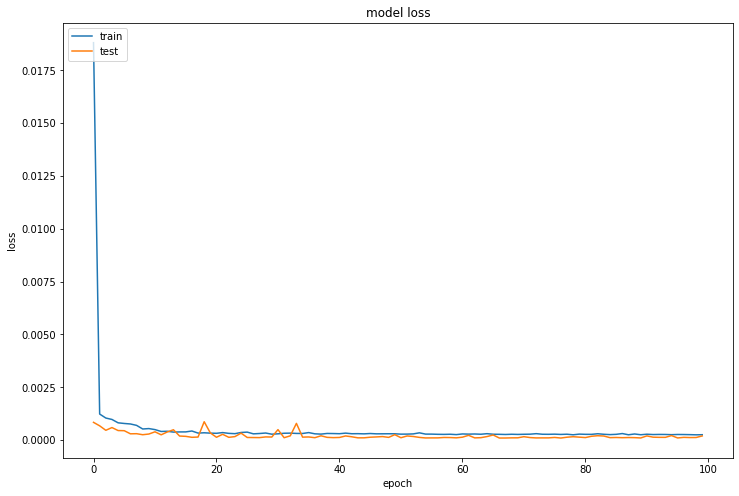

In [62]:
plt.figure(figsize=(12,8))
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict Test Set

In [63]:
predict_LSTM=LSTM_model.predict(x_test_multi)

31/31 [==============================] - 1s 18ms/step


In [64]:
predict_LSTM.shape

(974, 3)

## MSE

In [65]:
mse_LSTM= mean_squared_error(y_test_multi, predict_LSTM)

In [66]:
mse_LSTM

0.00019865339350538054

## Inverse Prediction

In [67]:
predict_LSTM_inv=scaler_y.inverse_transform(predict_LSTM)
#y_test_single_inv=scaler.inverse_transform(y_test_single)

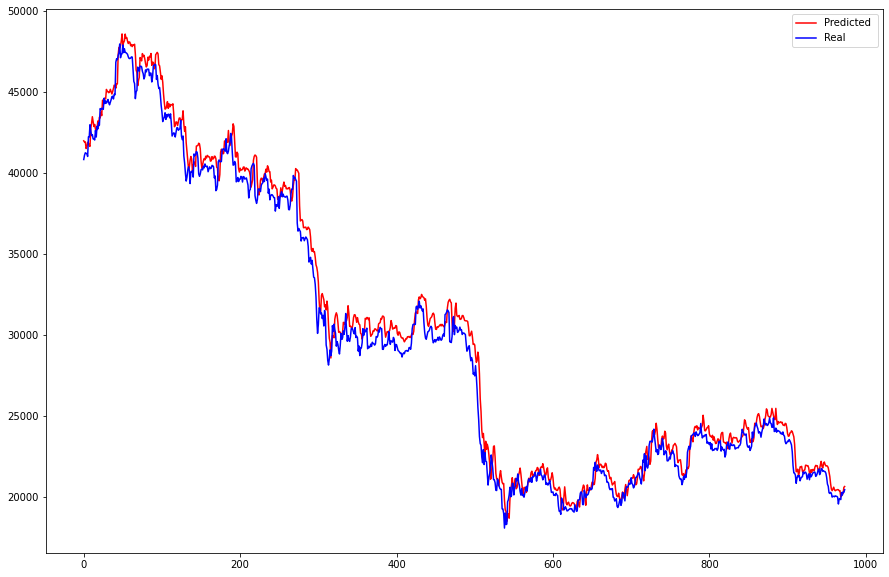

In [68]:
fig = plt.figure(figsize = (15,10))
plt.plot(predict_LSTM_inv[:,2], color='r', label='Predicted ')
plt.plot(y_test_multi_inv[:,2], color='b', label='Real ')
plt.legend()

## predict next step

In [69]:
next_step_LSTM=LSTM_model.predict(input_samples)
next_step_LSTM.shape

1/1 [==============================] - 0s 33ms/step


(1, 3)

In [70]:
next_step_LSTM

array([[0.1979241 , 0.20060234, 0.19941635]], dtype=float32)

In [71]:
next_step_LSTM_inv=scaler_y.inverse_transform(next_step_LSTM)

In [72]:
next_step_LSTM_inv

array([[20542.033, 20702.139, 20631.24 ]], dtype=float32)

# CNN

In [73]:
from keras.layers import BatchNormalization

In [74]:

CNN_model= Sequential()
CNN_model.add(Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=x_train_multi.shape[-2:]))
#CNN_model.add(Dropout(0.2))
#CNN_model.add(BatchNormalization())
#CNN_model.add(MaxPooling1D(pool_size=2))
# CNN_model.add(BatchNormalization())
# CNN_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# CNN_model.add(Dropout(0.2))
# CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling1D(pool_size=3))
# CNN_model.add(BatchNormalization())
CNN_model.add(Flatten())
CNN_model.add(Dense(64, activation='relu'))
# CNN_model.add(Dropout(0.2))
# CNN_model.add(BatchNormalization())
CNN_model.add(Dense(n_step,activation='selu'))
CNN_model.compile(loss='mse', optimizer='adam')



In [75]:
history_CNN=CNN_model.fit(x_train_multi,y_train_multi,
                                            epochs=100,batch_size=16,validation_data=(x_test_multi,y_test_multi))

Epoch 1/100
249/249 [==============================] - 2s 5ms/step - loss: 0.0046 - val_loss: 6.8402e-04
Epoch 2/100
249/249 [==============================] - 1s 4ms/step - loss: 9.4781e-04 - val_loss: 5.2323e-04
Epoch 3/100
249/249 [==============================] - 1s 4ms/step - loss: 7.7463e-04 - val_loss: 8.3735e-04
Epoch 4/100
249/249 [==============================] - 1s 4ms/step - loss: 6.8403e-04 - val_loss: 3.3683e-04
Epoch 5/100
249/249 [==============================] - 1s 4ms/step - loss: 5.6863e-04 - val_loss: 1.9362e-04
Epoch 6/100
249/249 [==============================] - 1s 4ms/step - loss: 5.1658e-04 - val_loss: 3.3152e-04
Epoch 7/100
249/249 [==============================] - 1s 4ms/step - loss: 4.8114e-04 - val_loss: 2.1288e-04
Epoch 8/100
249/249 [==============================] - 1s 4ms/step - loss: 3.9649e-04 - val_loss: 2.5742e-04
Epoch 9/100
249/249 [==============================] - 1s 4ms/step - loss: 4.0294e-04 - val_loss: 1.7329e-04
Epoch 10/100
249/249 [=

## learning curve

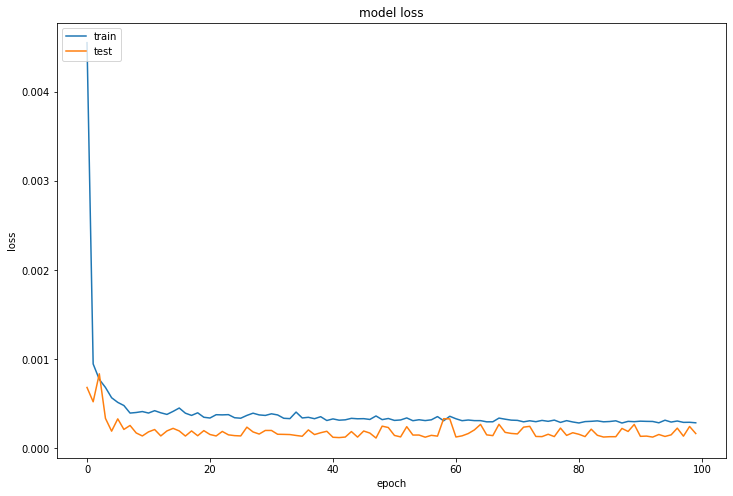

In [76]:
plt.figure(figsize=(12,8))
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict Test Set

In [77]:
predict_CNN=CNN_model.predict(x_test_multi)

31/31 [==============================] - 0s 3ms/step


In [78]:
predict_CNN.shape

(974, 3)

## MSE

In [79]:
mse_CNN= mean_squared_error(y_test_multi, predict_CNN)

In [80]:
mse_CNN

0.00016673640441383313

## Inverse Prediction

In [81]:
predict_CNN_inv=scaler_y.inverse_transform(predict_CNN)
# y_test_single_inv=scaler.inverse_transform(y_test_single)

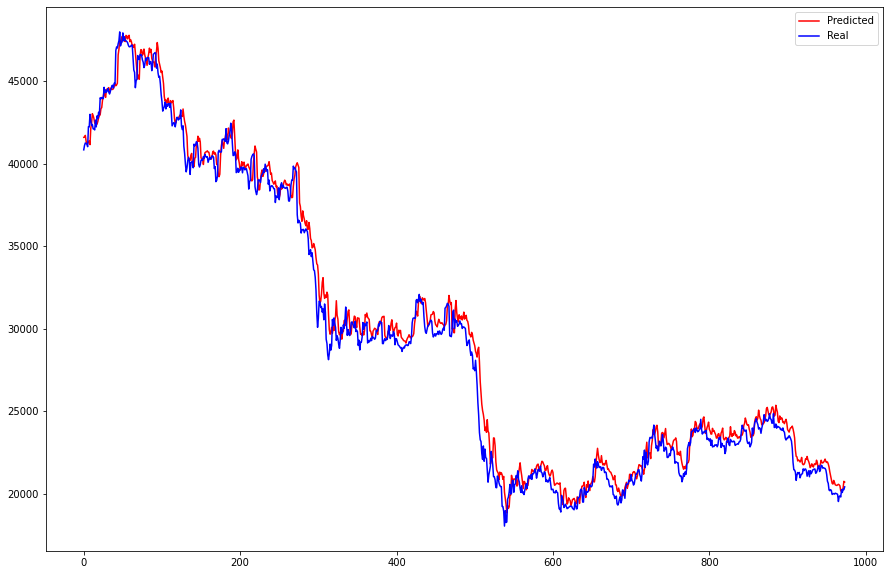

In [82]:
fig = plt.figure(figsize = (15,10))
plt.plot(predict_CNN_inv[:,2], color='r', label='Predicted')
plt.plot(y_test_multi_inv[:,2], color='b', label='Real')
plt.legend()

## predict next step

In [83]:
input_samples=x_test_multi[-1:,:,:]
input_samples.shape

(1, 23, 4)

In [84]:
next_step_RNN=RNN_model.predict(input_samples)
next_step_RNN.shape

1/1 [==============================] - 0s 34ms/step


(1, 3)

In [85]:
next_step_RNN

array([[0.18371922, 0.18882973, 0.18696232]], dtype=float32)

In [86]:
next_step_RNN_inv=scaler_y.inverse_transform(next_step_RNN)

In [87]:
next_step_RNN_inv

array([[19692.855, 19998.365, 19886.73 ]], dtype=float32)

# MLP

In [88]:
x_train_multi_2d=x_train_multi.reshape(x_train_multi.shape[0],x_train_multi.shape[1]*x_train_multi.shape[2])
x_test_multi_2d=x_test_multi.reshape(x_test_multi.shape[0],x_test_multi.shape[1]*x_test_multi.shape[2])

In [89]:
MLP_model = Sequential()
MLP_model.add(Dense(100, activation='relu', input_dim=x_train_multi_2d.shape[1]))
MLP_model.add(Dense(60, activation='relu'))
MLP_model.add(Dense(40, activation='relu'))
MLP_model.add(Dense(40, activation='relu'))
MLP_model.add(Dense(40, activation='relu'))
MLP_model.add(Dense(50, activation='relu'))

MLP_model.add(Dense(n_step,activation='selu'))
MLP_model.compile(loss='mse', optimizer='adam')

In [90]:
history_MLP=MLP_model.fit(x_train_multi_2d,y_train_multi,
                                            epochs=100,batch_size=16,validation_data=(x_test_multi_2d,y_test_multi))

Epoch 1/100
249/249 [==============================] - 2s 5ms/step - loss: 0.0080 - val_loss: 4.3990e-04
Epoch 2/100
249/249 [==============================] - 1s 4ms/step - loss: 6.2144e-04 - val_loss: 3.8130e-04
Epoch 3/100
249/249 [==============================] - 1s 4ms/step - loss: 5.3780e-04 - val_loss: 2.5708e-04
Epoch 4/100
249/249 [==============================] - 1s 4ms/step - loss: 5.4396e-04 - val_loss: 1.6197e-04
Epoch 5/100
249/249 [==============================] - 1s 4ms/step - loss: 6.1515e-04 - val_loss: 1.6387e-04
Epoch 6/100
249/249 [==============================] - 1s 4ms/step - loss: 4.4667e-04 - val_loss: 1.5461e-04
Epoch 7/100
249/249 [==============================] - 1s 4ms/step - loss: 5.1427e-04 - val_loss: 1.9863e-04
Epoch 8/100
249/249 [==============================] - 1s 4ms/step - loss: 4.9832e-04 - val_loss: 3.0370e-04
Epoch 9/100
249/249 [==============================] - 1s 4ms/step - loss: 5.0464e-04 - val_loss: 1.8078e-04
Epoch 10/100
249/249 [=

## learning curve

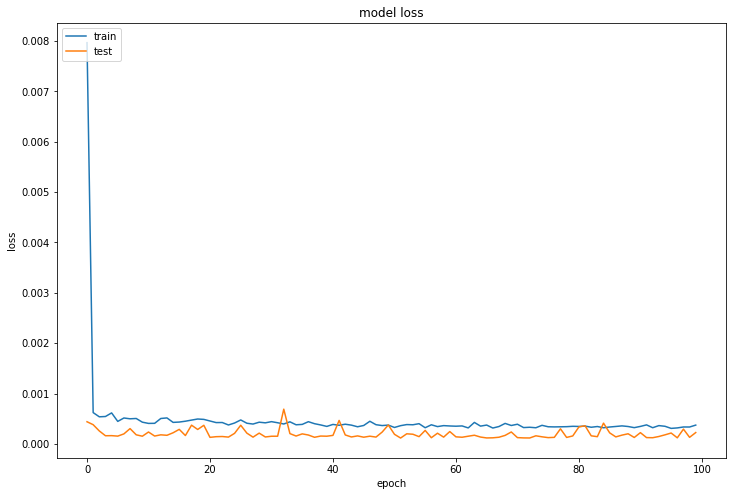

In [91]:
plt.figure(figsize=(12,8))
plt.plot(history_MLP.history['loss'])
plt.plot(history_MLP.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Predict Test Set

In [92]:

predict_MLP=MLP_model.predict(x_test_multi_2d)

31/31 [==============================] - 0s 2ms/step


In [93]:
predict_MLP.shape

(974, 3)

## MSE

In [94]:
mse_MLP= mean_squared_error(y_test_multi, predict_MLP)

In [95]:
mse_MLP

0.00022540419531639426

## Inverse Prediction

In [96]:
predict_MLP_inv=scaler_y.inverse_transform(predict_MLP)
#y_test_single_inv=scaler.inverse_transform(y_test_single)

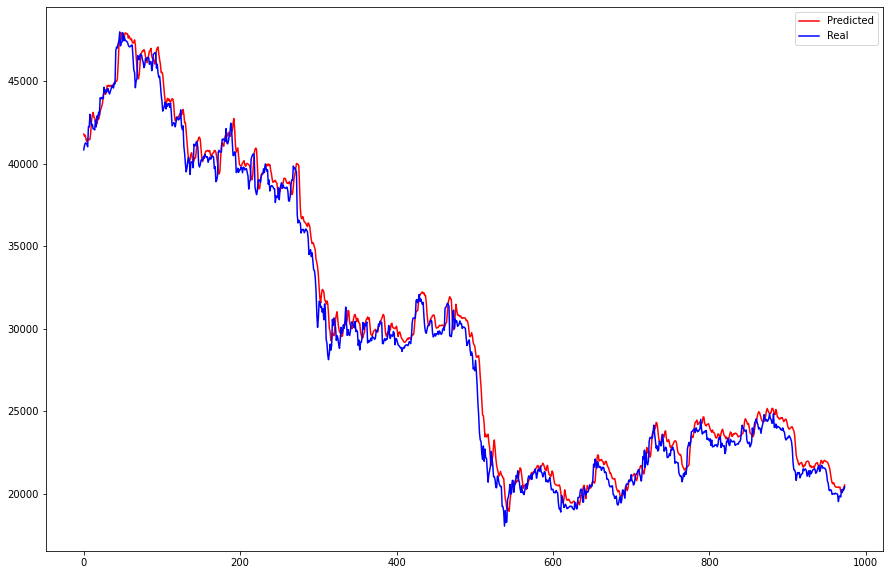

In [97]:
fig = plt.figure(figsize = (15,10))
plt.plot(predict_MLP_inv[:,2], color='r', label='Predicted')
plt.plot(y_test_multi_inv[:,2], color='b', label='Real')
plt.legend()

## predict next step

In [98]:
input_samples_MLP=x_test_multi_2d[-1:,:]
input_samples_MLP.shape

(1, 92)

In [99]:
next_step_MLP=MLP_model.predict(input_samples_MLP)
next_step_MLP.shape

1/1 [==============================] - 0s 29ms/step


(1, 3)

In [100]:
next_step_MLP

array([[0.1978886 , 0.20113319, 0.1980877 ]], dtype=float32)

In [101]:
next_step_MLP_inv=scaler_y.inverse_transform(next_step_MLP)

In [102]:
next_step_MLP_inv

array([[20539.91 , 20733.873, 20551.812]], dtype=float32)

# Result Comparision

In [103]:
result={'Mlp':mse_MLP,'SimpleRNN':mse_RNN,'GRU':mse_GRU,'LSTM':mse_LSTM,'CNN':mse_CNN}

In [104]:
result=pd.DataFrame.from_dict(result,orient='index')

In [105]:
result

,0
Mlp,0.000225
SimpleRNN,0.000286
GRU,0.000108
LSTM,0.000199
CNN,0.000167


<AxesSubplot:>

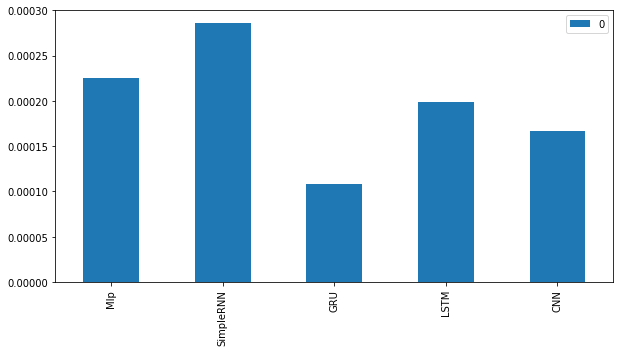

In [106]:
result.plot(kind='bar',figsize=(10,5))